In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from cebra_utils import *

In [2]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
output_model_path = 'models/cebra_model_complete3.pt'
neural_data_directory= []
behavior_data_directory = []

In [4]:
data_directory = '/mnt/teams/Tsuchitori/IV2_reaching_30hz_30frame_DFF/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

In [5]:
def init_dataloader(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size=1, cebra_offset=None ):
    datasets = []
    print('loading data')
    for session in zip(brain_data, feature_data, label_data):
        brain_data_tensor  = torch.FloatTensor(session[0])
        feature_data_tensor = torch.FloatTensor(session[1])
        label_data_tensor = torch.Tensor(session[2]).type(torch.LongTensor)
        datasets.append(cebra.data.datasets.TensorDataset(brain_data_tensor, continuous=feature_data_tensor, discrete=label_data_tensor, offset=cebra_offset))
    dataset_collection = cebra.data.datasets.DatasetCollection(*datasets)
    return cebra.data.multi_session.MixedMultiSessionDataLoader(
        dataset=dataset_collection,
        batch_size=batch_size,
        num_steps=num_steps,
        time_offset=time_offset,
        conditional=conditional,
    ).to('cuda')

def init_dataloader_single_session(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size=1, cebra_offset=None ):
    brain_data_tensor  = torch.FloatTensor(brain_data)
    feature_data_tensor = torch.FloatTensor(feature_data)
    label_data_tensor = torch.Tensor(label_data).type(torch.LongTensor)
    dataset = cebra.data.datasets.TensorDataset(brain_data_tensor, continuous=feature_data_tensor, discrete=label_data_tensor, offset=cebra_offset)
    return cebra.data.single_session.MixedDataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_steps=num_steps,
        time_offset=time_offset,
        conditional=conditional,
    ).to('cuda')



In [6]:
def flatten_features(features):
    return [(feature.flatten()) for feature in features]

def load_partial_data2D(brain_paths, behvaior_paths, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data, label_data = [], [], []
    for path in zip(brain_paths, behvaior_paths):
        print('importing from: ' + path[0] + ' and ' + path[1])
        brain_data_temp, name_data_temp = import_data(path[0], lambda x: process_brain(x), min, max)
        feature_data_temp, _ = import_data(path[1], lambda x: np.squeeze(x), min, max)
        brain_data.append(flatten_data(brain_data_temp))
        feature_data.append(flatten_data(feature_data_temp))
        # Get move nomove labels from name data 
        label_data_temp = []
        for iter, name in enumerate(name_data_temp):
            if name.split('_')[0] == 'nomove':
                label_data_temp.extend( np.zeros(len(brain_data_temp[iter])))
            else:
                label_data_temp.extend( np.ones(len(brain_data_temp[iter])))
        label_data.append(label_data_temp)
        del brain_data_temp
        del feature_data_temp
        del label_data_temp
        del name_data_temp
        del _
        gc.collect()
    return init_dataloader(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

def load_single_session(brain_path, behavaior_path, min, max, num_steps, time_offset, conditional, batch_size, cebra_offset):
    brain_data, feature_data, label_data = [], [], []
    brain_data_temp, name_data_temp = import_data(brain_path, lambda x: process_brain(x), min, max)
    feature_data_temp, _ = import_data(behavaior_path, lambda x: np.squeeze(x), min, max)
    brain_data.append(flatten_data(brain_data_temp))
    feature_data.append(flatten_data(feature_data_temp))
    # Get move nomove labels from name data 
    for iter, name in enumerate(name_data_temp):
        if name.split('_')[0] == 'nomove':
            label_data.extend( np.zeros(len(brain_data_temp[iter])))
        else:
            label_data.extend( np.ones(len(brain_data_temp[iter])))
    # squeeze brain and feature data
    brain_data = np.squeeze(np.array(brain_data))
    feature_data = np.squeeze(np.array(feature_data))
    return init_dataloader_single_session(brain_data, feature_data, label_data, num_steps, time_offset, conditional, batch_size, cebra_offset)

In [7]:
## Creat and train the model in partial batches of data
def partial_train(brain_paths, behavior_paths, min, max, slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset, hidden_units, output_dimension, model_name, device, saved_model = None):
    ## Load dataloader for first slice of data
    print('Loading data')
    dataloader= load_partial_data2D(brain_paths, behavior_paths, min, min+slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset)
    print('Creating model')
    ## create list of models
    model = torch.nn.ModuleList([
    cebra.models.init(model_name, (128 * 128),
                        hidden_units, output_dimension, True)
    for _ in range(len(list(dataloader.dataset.iter_sessions())))
    ]).to(device)
    if saved_model is not None:
        model.__setstate__(saved_model)

    ## Load criterion
    criterion = cebra.models.criterions.LearnableCosineInfoNCE(temperature=1, min_temperature=0.1).to(device)
    start_state = criterion.state_dict()
    ## Load optimizer
    optimizer = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr=0.001)

    print('Loading solver')
    ## Load solver and train on first slice of data
    solver = cebra.solver.MultiSessionSolver(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        tqdm_on=True,
    ).to(device)
    print('Training on slice 1')
    solver.fit(dataloader.to(device),
                save_frequency=500,
                logdir='runs',)
    torch.save(solver, output_model_path)
    for i in range(2, int((max-min)/slice_size)+1):
        del dataloader
        gc.collect()
        criterion.__setstate__(start_state)
        ## Load next slice of data
        dataloader= load_partial_data2D(brain_paths, behavior_paths, min+slice_size*(i-1), min+slice_size*i, num_steps, time_offset, conditional, batch_size, cebra_offset).to(device)
        ## Train on next slice of data
        print('Training on slice '+str(i))
        solver.fit(dataloader,
                save_frequency=500,
                logdir='runs',)        
        torch.save(model, output_model_path)
    print('Training complete, saving model')
    torch.save(solver, output_model_path)
    return solver


In [8]:
## Creat and train the model in partial batches of data
def partial_train_single_session(brain_path, behavior_path, min, max, slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset, hidden_units, output_dimension, model_name, device, saved_model = None):
    ## Load dataloader for first slice of data
    print('Loading data')
    dataloader= load_single_session(brain_path, behavior_path, min, min+slice_size, num_steps, time_offset, conditional, batch_size, cebra_offset)
    print('Creating model')
    ## create list of models
    model = cebra.models.init(model_name, (128 * 128),
                        hidden_units, output_dimension, normalize=True)

    if saved_model is not None:
        model.__setstate__(saved_model)

    ## Load criterion
    criterion = cebra.models.criterions.LearnableCosineInfoNCE(temperature=1, min_temperature=0.1).to(device)
    start_state = criterion.state_dict()
    ## Load optimizer
    optimizer = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr=0.001)

    print('Loading solver')
    ## Load solver and train on first slice of data
    solver = cebra.solver.SingleSessionSolver(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        tqdm_on=True,
    ).to(device)
    print('Training on slice 1')
    solver.fit(dataloader.to(device),
                save_frequency=500,
                logdir='runs',)
    torch.save(solver, output_model_path)
    for i in range(2, int((max-min)/slice_size)+1):
        del dataloader
        gc.collect()
        criterion.__setstate__(start_state)
        ## Load next slice of data
        dataloader= load_single_session(brain_path, behavior_path, min+slice_size*(i-1), min+slice_size*i, num_steps, time_offset, conditional, batch_size, cebra_offset).to(device)
        ## Train on next slice of data
        print('Training on slice '+str(i))
        solver.fit(dataloader,
                save_frequency=500,
                logdir='runs',)        
        torch.save(model, output_model_path)
    print('Training complete, saving model')
    torch.save(solver, output_model_path)
    return solver


In [9]:
cebra.models.get_options()

['offset10-model',
 'offset10-model-mse',
 'offset5-model',
 'offset1-model-mse',
 'offset1-model',
 'offset1-model-v2',
 'offset1-model-v3',
 'offset1-model-v4',
 'offset1-model-v5',
 'offset40-model-4x-subsample',
 'resample-model',
 'offset20-model-4x-subsample',
 'resample5-model',
 'offset4-model-2x-subsample',
 'resample1-model',
 'supervised10-model',
 'supervised1-model',
 'offset36-model',
 'offset36-model-dropout',
 'offset36-model-more-dropout',
 'convolutional-model-offset11',
 'convolutional-model-30frame']

Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_13_IV2_train_3.pt
Loading data


Creating model
Loading solver
Training on slice 1


pos:  1.0387 neg:  2.9910 total:  4.0297 temperature:  0.1000: 100%|██████████| 8000/8000 [03:36<00:00, 36.97it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_13_IV2_train_2.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  1.2510 neg:  2.9354 total:  4.1865 temperature:  0.1000: 100%|██████████| 8000/8000 [03:33<00:00, 37.47it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_17_IV2_train.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  0.9520 neg:  2.8587 total:  3.8107 temperature:  0.1000: 100%|██████████| 8000/8000 [03:34<00:00, 37.23it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_16_IV2_train.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  0.8486 neg:  3.0319 total:  3.8805 temperature:  0.1000: 100%|██████████| 8000/8000 [04:20<00:00, 30.70it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_18_IV2_train.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  0.7166 neg:  2.9451 total:  3.6617 temperature:  0.1000: 100%|██████████| 8000/8000 [03:47<00:00, 35.24it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_15_IV2_train.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  1.0110 neg:  2.9067 total:  3.9176 temperature:  0.1000: 100%|██████████| 8000/8000 [03:38<00:00, 36.61it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_19_IV2_train.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  0.6077 neg:  2.9777 total:  3.5854 temperature:  0.1000: 100%|██████████| 8000/8000 [03:43<00:00, 35.71it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_12_IV2_train_2.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  1.1578 neg:  2.8862 total:  4.0440 temperature:  0.1000: 100%|██████████| 8000/8000 [03:17<00:00, 40.49it/s]


Training complete, saving model
Training model: models/single_session-v2/cebra_model_flattened_offset1-2019_7_13_IV2_train_1.pt
Loading data
Creating model
Loading solver
Training on slice 1


pos:  1.2784 neg:  2.8827 total:  4.1611 temperature:  0.1000: 100%|██████████| 8000/8000 [02:53<00:00, 46.08it/s]


Training complete, saving model


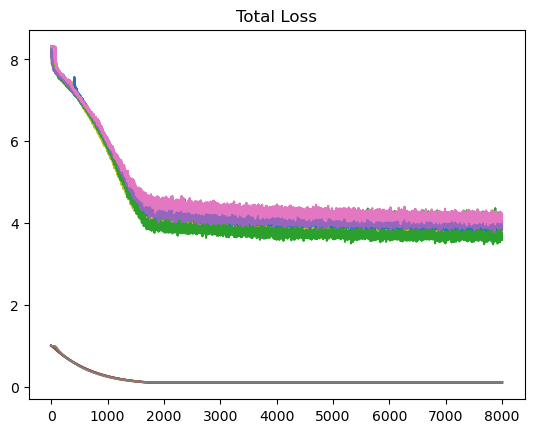

In [10]:
for neural_path, dino_path in zip(neural_data_paths, dino_paths):
  output_model_path = 'models/single_session-v2/cebra_model_flattened_offset1-' + neural_path.split('/')[-1] + '.pt'  
  print('Training model: ' + output_model_path)
  model = partial_train_single_session(neural_path,
              dino_path,
              min=0.0,
              max=0.8,
              slice_size=0.8,
              num_steps=8000,
              time_offset=15,
              conditional='time_delta',
              batch_size=4096,
              cebra_offset=cebra.data.datatypes.Offset(0,1),
              hidden_units=512,
              output_dimension=16,
              model_name='offset1-model-v5',
              device='cuda'  
            )
  plt.plot(model.log['total'])
  plt.plot(model.log['temperature'])
  plt.title('Total Loss')

In [11]:
model = torch.load('models/cebra_model_flattened_offset1-v22020_11_9_MV1_run.pt')
plt.plot(model.log['total'])
plt.plot(model.log['temperature'])
plt.title('Total Loss')


FileNotFoundError: [Errno 2] No such file or directory: 'models/cebra_model_flattened_offset1-v22020_11_9_MV1_run.pt'

In [ ]:
model_list = []
for model_path in os.listdir('models/single_session-v2/'):
  model = torch.load('models/single_session-v2/' + model_path).model
  model_list.append(model)
  print(model_path)
# convert into torch model list
model_list = torch.nn.ModuleList(model_list)
# save model list
torch.save(model_list, 'models/single_session-v2/cebra_model_list.pt')

cebra_model_flattened_offset1-v22020_11_2_MV1_run.pt
cebra_model_flattened_offset1-v22020_11_9_MV1_run.pt
cebra_model_flattened_offset1-v22021_1_12_MV1_run.pt
cebra_model_flattened_offset1-v22020_12_10_MV1_run.pt
cebra_model_flattened_offset1-v22021_1_8_MV1_run.pt
cebra_model_flattened_offset1-v22020_11_17_MV1_run.pt
cebra_model_flattened_offset1-v22020_11_23_MV1_run.pt
cebra_model_flattened_offset1-v22020_12_4_MV1_run.pt


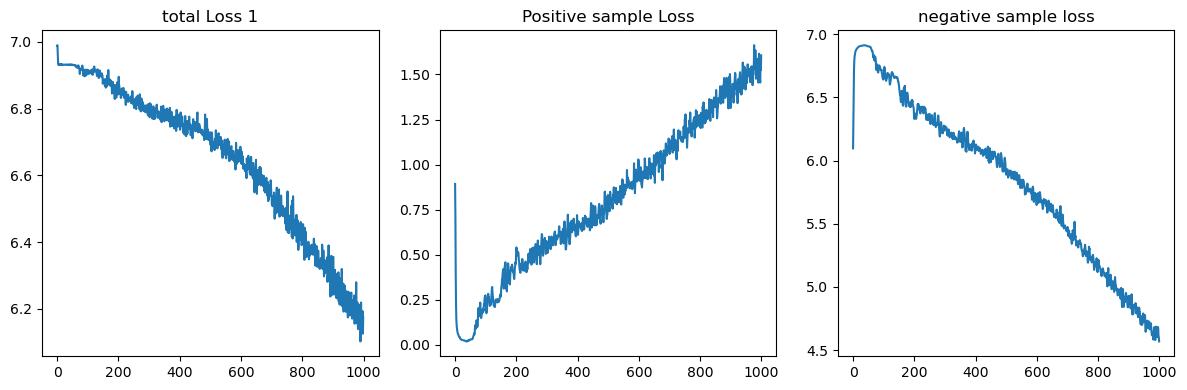

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as per your requirements
axes[0].plot(model.log['total'])  # Replace x1 and y1 with your data for the first plot
axes[0].set_title('total Loss 1')

# Plot the second value
axes[1].plot(model.log['pos'])  # Replace x2 and y2 with your data for the second plot
axes[1].set_title('Positive sample Loss')

# Plot the third value
axes[2].plot(model.log['neg'])  # Replace x3 and y3 with your data for the third plot
axes[2].set_title('negative sample loss')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()